# Automatic mask generator with Segment Anything from Meta
#
#
This notebook demonstrates:
- 1. Loading and displaying the original stone image.
- 2. Using SAM’s automatic mask generator to segment the stones.
- 3. Building a final binary mask from the automatic segmentation.
- 4. Refining the mask by adding bounding box–based prompts for missing stones.
- 5. Merging both results into a final combined mask.
- 6. Splitting the refined stone dataset into 256×256 patches and removing non-stone elements.

### Step 1: Imports and Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import importlib
import torch
import sys
import os

In [2]:
libraries = ["numpy", "torch", "matplotlib", "cv2", "math", "supervision"]
for lib in libraries:
    try:
        importlib.import_module(lib)
        print(f"{lib} ✅ Installed")
    except ImportError:
        print(f"{lib} ❌ NOT Installed")

numpy ✅ Installed
torch ✅ Installed
matplotlib ✅ Installed
cv2 ✅ Installed
math ✅ Installed
supervision ✅ Installed


### Step 2: Define Utility Functions

This function overlays colored masks on an image for visualization.

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    # Sort masks by area (largest first)
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    # Create an RGBA overlay initialized with zeros in alpha channel
    img_overlay = np.ones((sorted_anns[0]['segmentation'].shape[0],
                             sorted_anns[0]['segmentation'].shape[1], 4))
    img_overlay[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        # Random color for each mask, with fixed alpha for transparency
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img_overlay[m] = color_mask
    ax.imshow(img_overlay)

### Step 3: Load and Display the Original Image
We load the image from disk and convert it from BGR to RGB.

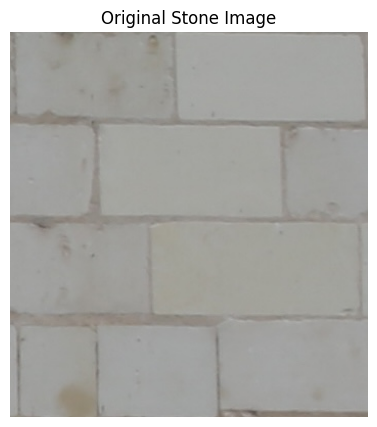

In [4]:
image_path = '../data/refined/img-stones/FSE_35_002.jpg'

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Convert BGR -> RGB

plt.figure(figsize=(5,5))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Original Stone Image")
plt.show()

### Step 4: Initialize the SAM Model
We load the SAM model and create an automatic mask generator.



In [5]:
sys.path.append("../third_party/segment-anything/")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print("Using device:", device)

Using device: cpu


In [6]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10, 
)

### Step 5: Generate and Explore Automatic Masks

We run SAM on the original image (without equalization) to generate segmentation masks.
Then we visualize the results.



In [7]:
masks = mask_generator.generate(image_rgb)

In [8]:
print("Number of masks generated:", len(masks))
print("Keys of the first mask:", masks[0].keys())

Number of masks generated: 29
Keys of the first mask: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


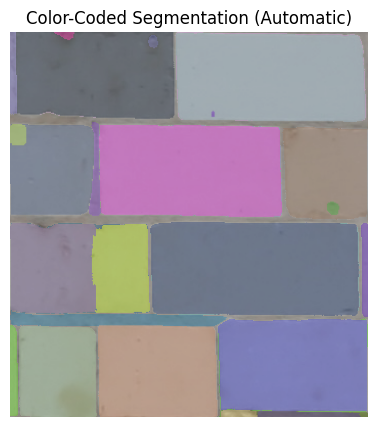

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(image_rgb)
show_anns(masks)
plt.axis('off')
plt.title("Color-Coded Segmentation (Automatic)")
plt.show()

### Step 6: Build the Final Binary Mask from Automatic Masks

This function builds a binary mask from the SAM predictions.
Stones will be white (255) and mortar black (0). We use a summation approach
followed by Otsu thresholding and a morphological close to fill small holes.


In [10]:
def build_totalmask(pred):
    """
    Builds a binary mask from SAM predictions.
    Stones = white (255), mortar = black (0).
    Fills small holes using morphological closing.
    """
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Get the image dimensions from the first mask
    height, width = pred[0]['segmentation'].shape
    total_mask = np.zeros((height, width), dtype=np.uint8)

    # Accumulate all masks using summation. (Note: This may merge overlapping regions.)
    for seg in pred:
        seg_bin = seg['segmentation'].astype(np.uint8)
        total_mask += seg_bin

    # Use Otsu thresholding to convert the summation into a binary mask.
    _, total_mask_bin = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Apply morphological closing to fill small holes.
    kernel = np.ones((2,2), np.uint8)
    total_mask_bin = cv2.morphologyEx(total_mask_bin, cv2.MORPH_CLOSE, kernel)

    plt.figure(figsize=(5,5))
    plt.imshow(total_mask_bin, cmap='gray')
    plt.title("Binary Mask of Stones (Automatic)")
    plt.axis('off')
    plt.show()

    return total_mask_bin

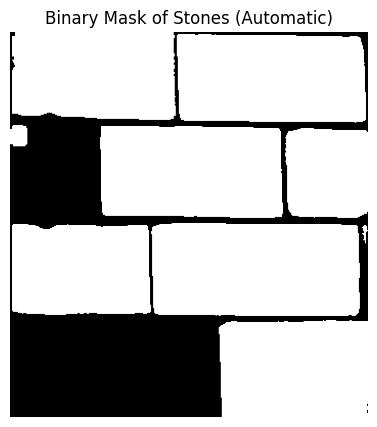

In [11]:
final_mask_bin = build_totalmask(masks)

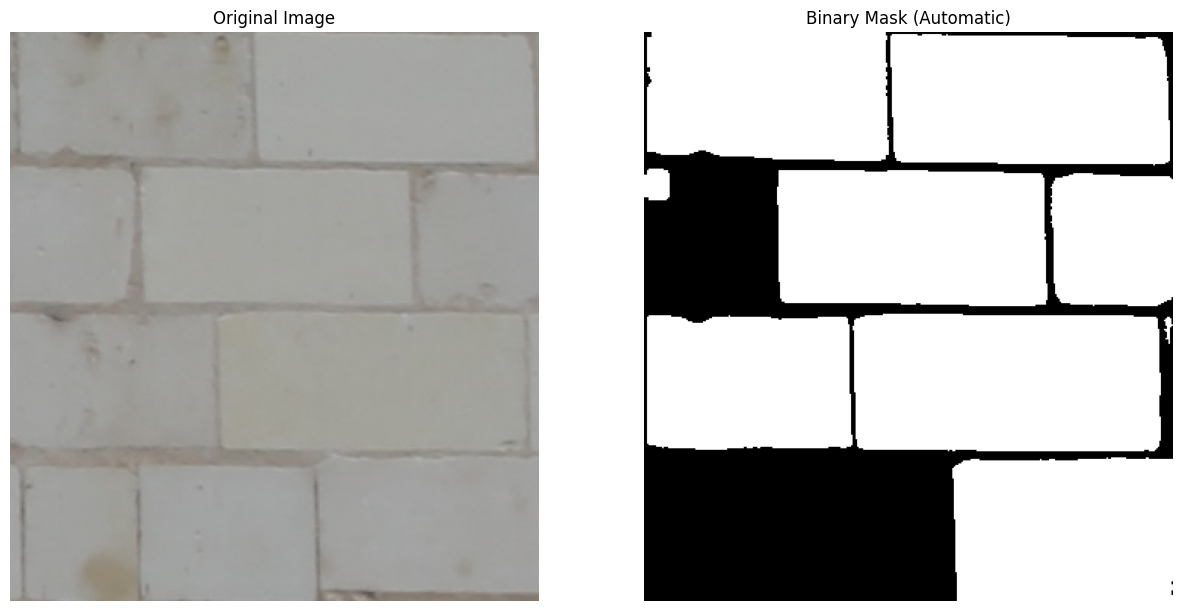

In [12]:
# Display the original image and the automatic binary mask side by side.
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(final_mask_bin, cmap='gray')
plt.title("Binary Mask (Automatic)")
plt.axis('off')
plt.show()


### Step 7: Bounding Box Prompts for Missing Stones

If the automatic mask missed certain stones, we can supply bounding box prompts.
Here, we paste the bounding boxes obtained from your external annotation script.

Boxes from local annotation: [array([  3, 288,   6, 373]), array([  6, 282,  86, 373]), array([ 87, 282, 203, 373]), array([204, 281, 344, 371]), array([343, 186, 348, 277]), array([  6,  81,  85, 176])]


Bounding box-based masks shape: (6, 377, 350)
Scores: tensor([[0.9363],
        [0.9688],
        [0.9680],
        [0.9528],
        [0.8989],
        [0.9636]])


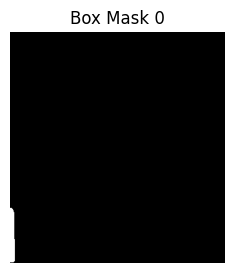

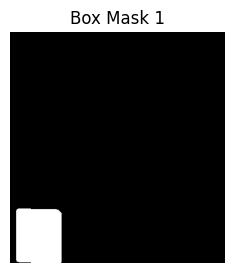

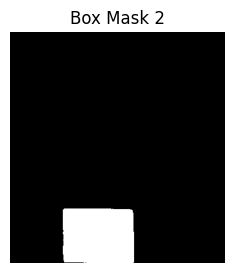

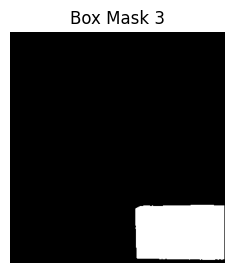

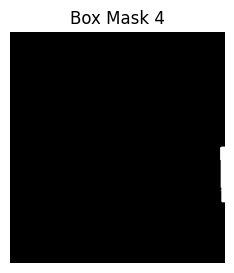

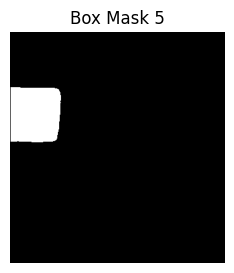

In [13]:
from segment_anything import SamPredictor
import numpy as np
import torch

# 1) Initialize SamPredictor using the same SAM model
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

# 2) Define bounding boxes from your manual annotation.
# Replace with the actual coordinates from create_boxes.py output.
# Those coordinates are in the format (x1, y1, x2, y2) for each box. Some of them are inside the folder 
# /annotations in boxe.json format.
boxes_raw = [
    (3, 288, 6, 373),
    (6, 282, 86, 373),
    (87, 282, 203, 373),
    (204, 281, 344, 371),
    (343, 186, 348, 277),
    (6, 81, 85, 176)
]

# Convert each tuple to a NumPy array
boxes = [np.array(b) for b in boxes_raw]
print("Boxes from local annotation:", boxes)

# Convert the list of boxes to a Torch tensor 
input_boxes = torch.tensor(boxes, device=mask_predictor.device)

# 3) Transform boxes for SAM (SAM expects transformed coordinates)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(
    input_boxes, 
    image_rgb.shape[:2]
)

# 4) Predict masks for each bounding box using SamPredictor.
masks_box, scores, logits = mask_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False
)

# Convert the resulting masks to NumPy (shape: [num_boxes, H, W])
masks_box = masks_box.squeeze(1).cpu().numpy()
print("Bounding box-based masks shape:", masks_box.shape)
print("Scores:", scores)

# Visualize each bounding box mask
for i in range(masks_box.shape[0]):
    plt.figure(figsize=(3,3))
    plt.imshow(masks_box[i], cmap='gray')
    plt.title(f"Box Mask {i}")
    plt.axis('off')
    plt.show()



# Merge Bounding Box Masks with the Automatic Mask
# We merge the masks from the bounding boxes with the automatic mask.
# This logical OR operation ensures any stone detected by bounding boxes is included.


# Convert the automatic mask to boolean
final_mask_bool = final_mask_bin.astype(bool)

# Merge each bounding box mask into the automatic mask
for i in range(masks_box.shape[0]):
    stone_bool = masks_box[i].astype(bool)
    final_mask_bool = np.logical_or(final_mask_bool, stone_bool)

# Convert the merged result back to binary (0 or 255)
combined_mask_bin = final_mask_bool.astype(np.uint8) * 255

# (Optional) Invert the final mask if desired (e.g., to have white stones on black background)
combined_mask_bin = cv2.bitwise_not(combined_mask_bin)

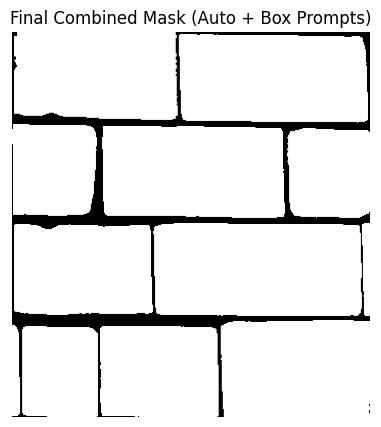

In [14]:
final_mask_bool = final_mask_bin.astype(bool)

# Merge each bounding box mask into the automatic mask
for i in range(masks_box.shape[0]):
    stone_bool = masks_box[i].astype(bool)
    final_mask_bool = np.logical_or(final_mask_bool, stone_bool)

# Convert the merged result back to 0 or 255
combined_mask_bin = final_mask_bool.astype(np.uint8) * 255

# (Optional) Invert the mask to get white stones on a black background.
# Uncomment the next line if desired:
# combined_mask_bin = cv2.bitwise_not(combined_mask_bin)

# Plot the final combined mask
plt.figure(figsize=(10,5))
plt.imshow(combined_mask_bin, cmap='gray')
plt.title("Final Combined Mask (Auto + Box Prompts)")
plt.axis("off")
plt.show()

### Step 9: Refine and Split the Stone Dataset into 256x256 Patches

In this step, we remove non-stone elements and split the image into patches.
We use the combined mask to filter out patches that do not contain a sufficient
amount of stone.


In [15]:
# Define patch extraction parameters.
patch_size = 256
stride = 128  # Controls overlap; 128 means 50% overlap

# Create a writable output directory for patches.
output_dir = '../data/patches/example'  # Adjust path as needed
os.makedirs(output_dir, exist_ok=True)

patch_count = 0
stone_threshold = 0.1  # Only save patches with at least 10% stone area in the mask

# Loop over the combined mask (and corresponding original image) to extract patches.
height, width = combined_mask_bin.shape
for y in range(0, height - patch_size + 1, stride):
    for x in range(0, width - patch_size + 1, stride):
        # Extract a patch from the binary mask.
        patch_mask = combined_mask_bin[y:y+patch_size, x:x+patch_size]
        # Extract the corresponding patch from the original image.
        patch_img = image_rgb[y:y+patch_size, x:x+patch_size]

        # Check if this patch has enough stone area (based on the mask)
        stone_pixels = cv2.countNonZero(patch_mask)
        if stone_pixels > stone_threshold * (patch_size * patch_size):
            # Convert the patch image to BGR for saving.
            patch_img_bgr = cv2.cvtColor(patch_img, cv2.COLOR_RGB2BGR)
            # Save the RGB image patch and the mask patch.
            cv2.imwrite(f"{output_dir}/patch_img_{patch_count}.png", patch_img_bgr)
            cv2.imwrite(f"{output_dir}/patch_mask_{patch_count}.png", patch_mask)
            patch_count += 1

print("Total patches saved:", patch_count)

Total patches saved: 1


### Step 10: Visualize the Final Combined Mask
We display the original image alongside the final combined mask.


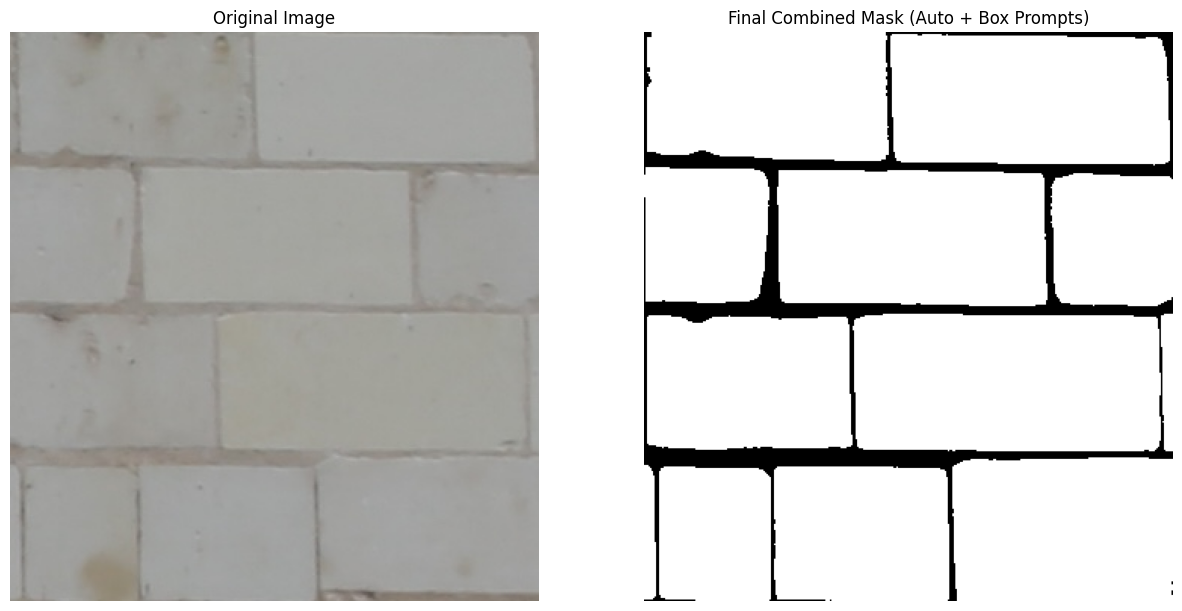

Done! This final mask includes automatic segmentation plus bounding box corrections, and the dataset has been split into 256x256 patches.


In [16]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(combined_mask_bin, cmap='gray')
plt.title("Final Combined Mask (Auto + Box Prompts)")
plt.axis('off')
plt.show()

# %%
print("Done! This final mask includes automatic segmentation plus bounding box corrections, and the dataset has been split into 256x256 patches.")

### Step 11: Visualize Extracted Patches with Corresponding Original Image Patches

This step extracts 256×256 patches from the final combined mask (combined_mask_bin)
and the original image (image_rgb) using a sliding window. For each patch that contains
at least 10% stone area (as measured by nonzero pixels in the mask), it displays a figure
with the original image patch (left) and its corresponding mask patch (right).

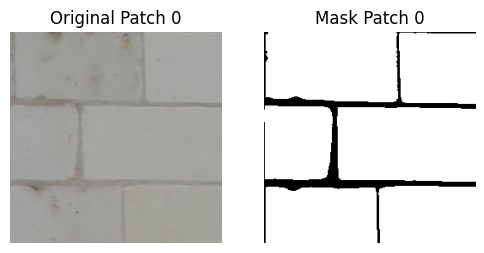

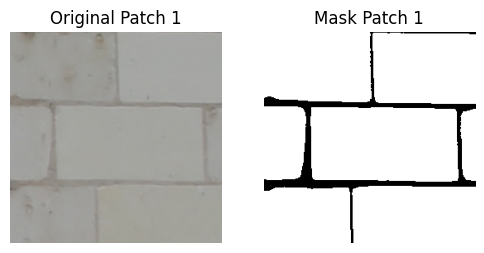

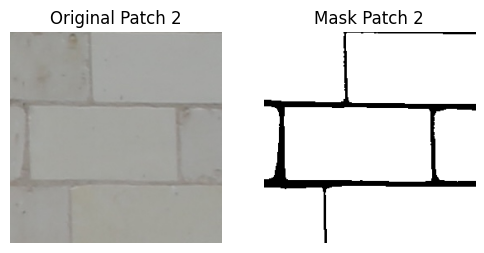

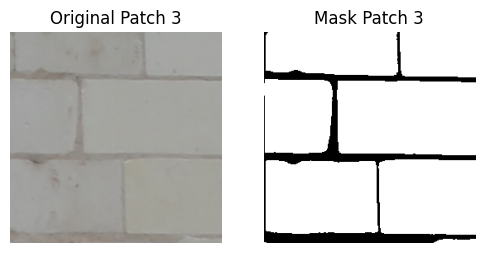

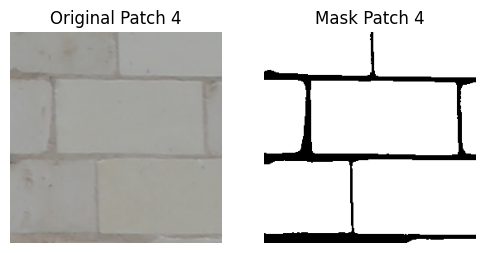

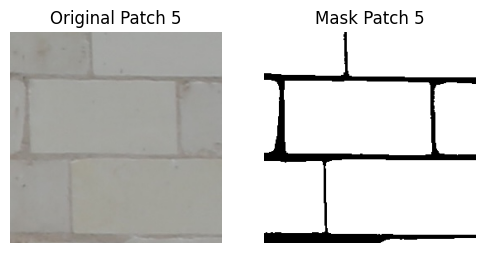

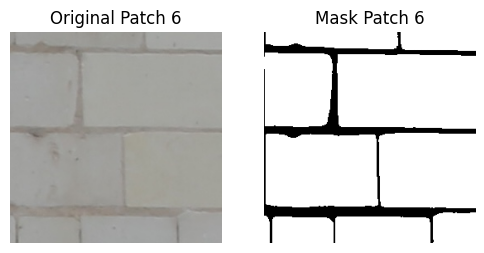

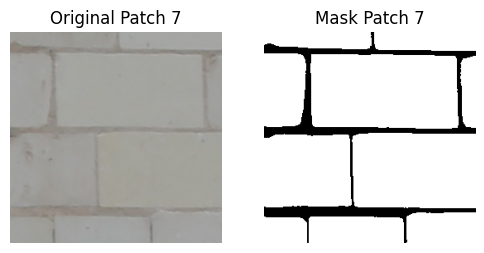

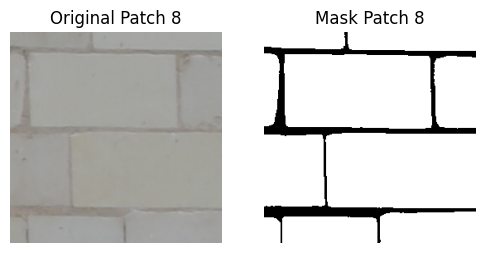

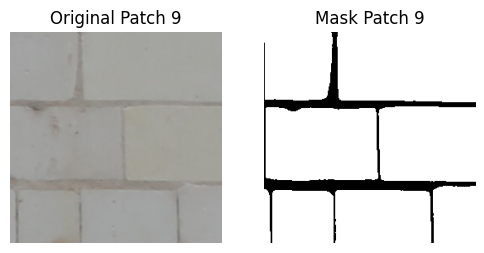

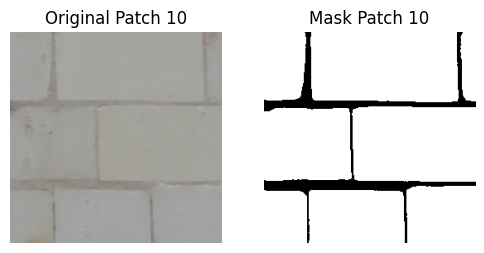

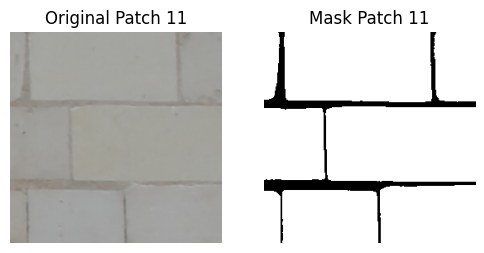

Displayed 12 patches.


In [ ]:
patch_size = 256
stride = 32  # stride is the step size for the sliding window
stone_threshold = 0.1  # Only display patches with at least 10% stone pixels

# Get dimensions of the final combined mask
mask_height, mask_width = combined_mask_bin.shape
patch_index = 0

# Loop over the mask using a sliding window
for y in range(0, mask_height - patch_size + 1, stride):
    for x in range(0, mask_width - patch_size + 1, stride):
        # Extract a 256x256 patch from the mask and the original image
        patch_mask = combined_mask_bin[y:y+patch_size, x:x+patch_size]
        patch_img = image_rgb[y:y+patch_size, x:x+patch_size]
        
        # Count non-zero pixels (stone area) in the mask patch
        stone_pixels = cv2.countNonZero(patch_mask)
        
        # Display only if the patch has at least 10% stone area
        if stone_pixels > stone_threshold * (patch_size * patch_size):
            plt.figure(figsize=(6,3))
            plt.subplot(1,2,1)
            plt.imshow(patch_img)
            plt.title(f"Original Patch {patch_index}")
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(patch_mask, cmap='gray')
            plt.title(f"Mask Patch {patch_index}")
            plt.axis('off')
            plt.show()
            patch_index += 1

print("Displayed", patch_index, "patches.")
